In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import imp
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sbs

import GPy

import shared as ip2
import csi

np.set_printoptions(precision=3, edgeitems=4, suppress=True, linewidth=1000)

In [3]:
inp = ip2.readCsvNamedMatrix(open("csi/testdata/Demo_DREAM.csv"))
print(inp.data)

[[    0.       50.      100.      150.    ...,   850.      900.      950.     1000.   ]
 [    0.709     0.228     0.08      0.008 ...,     0.622     0.719     0.733     0.65 ]
 [    0.522     0.848     0.793     0.556 ...,     0.6       0.72      0.677     0.642]
 [    0.631     0.562     0.479     0.506 ...,     0.465     0.403     0.405     0.487]
 ..., 
 [    0.02      0.02      0.014     0.016 ...,     0.034     0.013     0.013     0.015]
 [    0.462     0.592     0.396     0.355 ...,     0.497     0.588     0.566     0.72 ]
 [    0.21      0.198     0.18      0.107 ...,     0.212     0.256     0.23      0.228]
 [    0.655     0.217     0.122     0.078 ...,     0.776     0.808     0.717     0.94 ]]


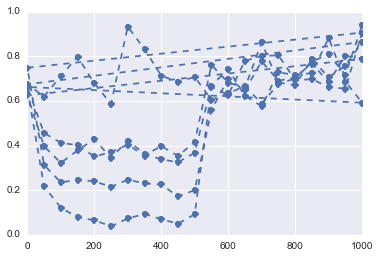

In [6]:
plt.plot(inp.data[0,:],inp.data[10,:],'o--');

In [106]:
x = np.unique(np.round(np.exp(np.linspace(np.log(10),np.log(250),51))).astype(int)).tolist()
y = [[len(list(csi.parentalSets(range(n),0,trunc))) for n in x] for trunc in [1,2,3]]

In [105]:
print(np.array(y).T)

[[     10      46     130]
 [     11      56     176]
 [     12      67     232]
 [     13      79     299]
 [     14      92     378]
 [     15     106     470]
 [     16     121     576]
 [     17     137     697]
 [     18     154     834]
 [     19     172     988]
 [     20     191    1160]
 [     22     232    1562]
 [     23     254    1794]
 [     25     301    2325]
 [     26     326    2626]
 [     28     379    3304]
 [     30     436    4090]
 [     32     497    4992]
 [     34     562    6018]
 [     36     631    7176]
 [     39     742    9178]
 [     41     821   10701]
 [     44     947   13288]
 [     47    1082   16262]
 [     50    1226   19650]
 [     53    1379   23479]
 [     57    1597   29317]
 [     61    1831   36051]
 [     65    2081   43745]
 [     69    2347   52463]
 [     74    2702   64898]
 [     78    3004   76154]
 [     84    3487   95368]
 [     89    3917  113653]
 [     95    4466  138510]
 [    102    5152  171802]
 [    108    5779  204264]
 

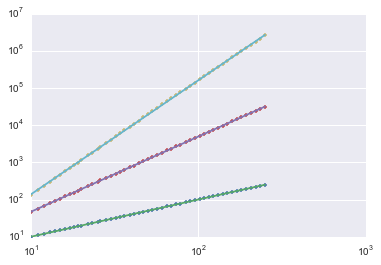

In [107]:
for yi in y:
    reg = sp.stats.linregress(np.log(x),np.log(yi))[0:2]

    plt.plot(x,yi,'.')
    plt.plot(x, np.exp(reg[0]*np.log(x)+reg[1]))

plt.xscale('log')
plt.yscale('log')

In [56]:
X = np.sort(sp.random.uniform(0,6,(20,1)),0)
Y1 = np.sin(X) + sp.random.normal(0, 0.1,(20,1))
Y2 = np.sin(X+2) + sp.random.normal(0, 0.1,(20,1))

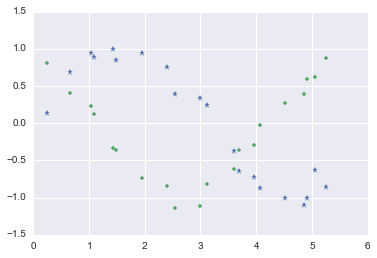

In [58]:
plt.plot(X,Y1,'*')
plt.plot(X,Y2,'.');

In [61]:
m1 = GPy.models.GPRegression(X,Y1)
m2 = GPy.models.GPRegression(X,Y2)
mm = csi.MetaModel([m1,m2])
mm

metamodel.,Value,Constraint,Prior,Tied to
GP regression_1.rbf.variance,1.0,+ve,,
GP regression_1.rbf.lengthscale,1.0,+ve,,
GP regression_1.Gaussian_noise.variance,1.0,+ve,,
GP regression.rbf.variance,1.0,+ve,,
GP regression.rbf.lengthscale,1.0,+ve,,
GP regression.Gaussian_noise.variance,1.0,+ve,,


In [83]:
pm1 = mm.parameters[1].parameters[0]
help(pm1.tie_together)

Help on method tie_together in module GPy.core.parameterization.parameter_core:

tie_together() method of GPy.core.parameterization.ties_and_remappings.Tie instance



In [96]:
x = mm.parameters[1].rbf.variance
y = mm.parameters[2].rbf.variance
x.tie_together(x)

TypeError: tie_together() takes 1 positional argument but 2 were given

In [55]:
X = sp.random.uniform(0,7,(20,1))
Y = np.sin(np.hstack([X,X+2,X+4])) + sp.randn(20,3) * 0.1

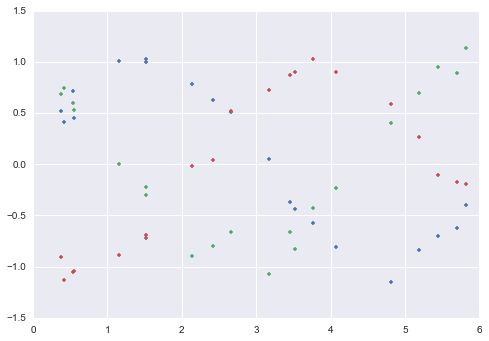

In [57]:
plt.plot(X,Y,'.');